# **Computer Vision** | MSc in Data Science and Engineering
## Assignment 2 - CAPTCHA Decoding
### Bruno Silva (up201508756) **|** João Carvalho (up201507023)
##### November, 2024


## TO DO

Report metrics on image level and on character level \
Report efficiency metrics like run time, number of parameters, number of FLOPs \
Do error analysis:
- identify the worst performing characters, try to improve on that front
- report common patterns like characters that are visibly difficult to identify, characters easily confusing like 0 and O, l and 1, etc. And maybe augment data on these to try to improve the model

Start from a very simple model as a baseline \
Try to get class representation percentages to see if there is any class imbalance \
Consider using grayscale images - maybe first with normal images and then grayscale to see if there's any difference in performance.

Treino:
- Separar todas as imagens em caracteres diferentes e guardar com a respetiva label (temos de ter a ordem porque os caracteres estão por ordem no nome). Basicamente criar um dataset novo. Treinar o modelo nestes caracteres individuais.

Teste:
- A pipeline vai começar por dividir a imagem em caracteres e guarda a ordem. Depois caracter a caracter aplica o modelo para saber que caracter se trata.
- O output são as predictions de cada caracter por ordem.

## Introduction


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms.functional as func
import torch.optim as optim
import os
import cv2 as cv

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Data (full images)

In [3]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform):

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # getting all image paths and labels
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)

            self.image_paths.append(img_path)

            label = img_name.split('.')[0] # removing the .png from the name
            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths) # to get the len(dataset)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # labels should be a list of characters
        label = list(label)
        return image, label


In [4]:
char_map = {ch: idx for idx, ch in enumerate("0123456789abcdefghijklmnopqrstuvwxyz")}
char_map["<PAD>"] = len(char_map)  # images are 4 or 5 characters long. PyTorch requires the labels to be of the same lenght
idx_to_char = {idx: ch for ch, idx in char_map.items()}  # Reverse mapping

char_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35,
 '<PAD>': 36}

In [5]:
# This function will deal with the label padding when applying the transform

def collate_fn(batch):

    images = []
    labels = []
    label_lengths = []

    for image, label in batch:
        images.append(image)
        # label to indices
        label_indices = torch.tensor([char_map[ch] for ch in label], dtype=torch.long)
        labels.append(label_indices)
        label_lengths.append(len(label_indices))

    # tensor (batch_size, 3, H, W)
    images = torch.stack(images)

    # padding the labels
    labels = pad_sequence(labels, batch_first=True, padding_value=char_map["<PAD>"])

    return images, labels, torch.tensor(label_lengths, dtype=torch.long)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [7]:
train_dir = 'CAPTCHA_dataset/soft/train'
test_dir = 'CAPTCHA_dataset/soft/test'

train_dataset = CaptchaDataset(root_dir=train_dir, transform=transform)
test_dataset = CaptchaDataset(root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

Image Batch Shape: torch.Size([32, 3, 100, 200])
Labels Shape: torch.Size([32, 5])
Label Lengths: tensor([4, 5, 4, 4, 4, 5, 4, 4, 5, 5, 4, 4, 4, 5, 5, 4, 4, 5, 4, 5, 5, 4, 5, 5,
        4, 5, 5, 4, 4, 4, 4, 5])


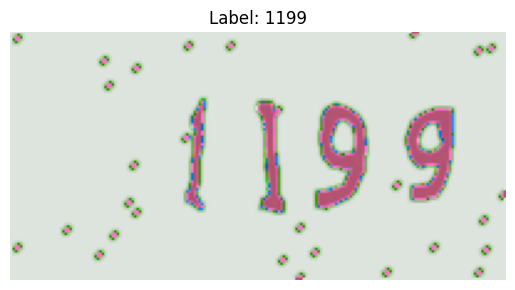

In [8]:
for images, labels, label_lengths in train_loader:
    print("Image Batch Shape:", images.shape)
    print("Labels Shape:", labels.shape)
    print("Label Lengths:", label_lengths)

    # first image in the batch
    first_image = images[0]
    label = labels[0]
    label_length = label_lengths[0]

    #converting label indices back to characters
    decoded_label = ''.join([idx_to_char[idx.item()] for idx in label[:label_length]])

    # this is for matplotlib to display
    first_image = func.to_pil_image(first_image)

    plt.imshow(first_image)
    plt.title(f"Label: {decoded_label}")
    plt.axis('off')
    plt.show()

    break

## Pre-processing

In [9]:
def segment_char(img_name, data_folder):

    img_path = os.path.join(data_folder, img_name)

    # image to grayscale
    image = cv.imread(img_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # grabbing contours
    _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # applying a threshold to remove small contours
    threshold = 100
    contours = [contour for contour in contours if cv.contourArea(contour) > threshold]

    # creating individual images based on the bounding boxes
    individual_images = []
    x_values = []
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        x_values.append(x)
        individual_image = image[y:y+h, x:x+w]
        individual_images.append(individual_image)

    # get the sorted idx of x_values -> this is to order the images from left to right, otherwise the contours are ordered in some other way
    sorted_idx = np.argsort(x_values)
    # sort individual_images based on sorted_idx
    individual_images = [individual_images[i] for i in sorted_idx]

    # new folder for individual images
    new_data_folder = data_folder + "_ind"

    # save individual images
    full_img_name = img_name.split('.')[0]
    for i, img in enumerate(individual_images):
        char = img_name[i]
        cv.imwrite(f'{new_data_folder}/{char}_{full_img_name}_{i}.png', img)

In [10]:
data_folder = "CAPTCHA_dataset/soft/"

for folder in ['train', 'test']:
    iter_data_folder = data_folder + folder

    for img in os.listdir(iter_data_folder):
        segment_char(img, iter_data_folder)

In [11]:
# morphological operations

def dilate(array, kernel_size):
    if np.max(array) == 1:
        array2 = (array * 255).astype(np.uint8)
    else:
        array2 = array.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8) 
    array_dilated = cv.dilate(array2, kernel, iterations=1) #dilate
    return array_dilated

def erode(array, kernel_size):
    if np.max(array) == 1:
        array2 = (array * 255).astype(np.uint8)
    else:
        array2 = array.astype(np.uint8)

    kernel = np.ones((kernel_size, kernel_size), np.uint8) 
    array_eroded = cv.erode(array2, kernel, iterations=1) #erode
    return array_eroded

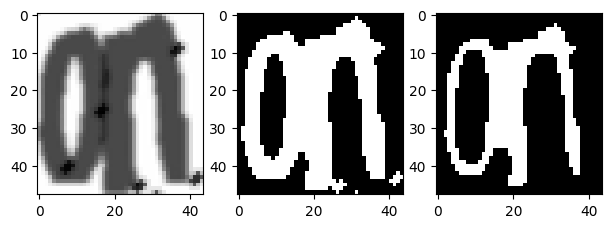

In [12]:
img_path = "CAPTCHA_dataset/soft/train_ind/s_vs0n_1.png"
img = cv.imread(img_path)
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

_, imgThreshold = cv.threshold(img, 150, 255, cv.THRESH_BINARY_INV)

img_eroded = erode(imgThreshold, 3)

plt.figure(figsize=(15,15))
plt.subplot(1,6,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,6,2)
plt.imshow(imgThreshold, cmap='gray')
plt.subplot(1,6,3)
plt.imshow(img_eroded, cmap='gray')

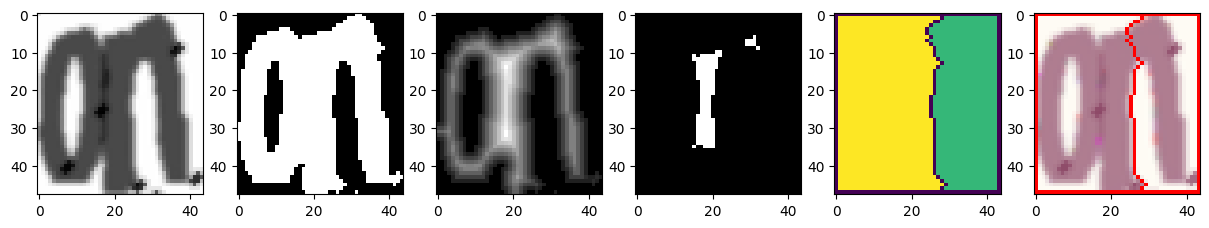

In [13]:
# WATERSHED ATTEMPT

img_path = "CAPTCHA_dataset/soft/train_ind/s_vs0n_1.png"
img = cv.imread(img_path)
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

_, imgThreshold = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)

distTrans = cv.distanceTransform(imgThreshold, cv.DIST_L2, 5) 

_, distThresh = cv.threshold(distTrans, 5, 255, cv.THRESH_BINARY)

distThresh = np.uint8(distThresh)
_, labels = cv.connectedComponents(distThresh)

labels = np.int32(labels)
mask = cv.watershed(imgRGB, labels)

imgRGB[mask == -1] = [255, 0, 0]


plt.figure(figsize=(15,15))
plt.subplot(1,6,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,6,2)
plt.imshow(imgThreshold, cmap='gray')
plt.subplot(1,6,3)
plt.imshow(distTrans, cmap='gray')
plt.subplot(1,6,4)
plt.imshow(distThresh, cmap='gray')
plt.subplot(1,6,5)
plt.imshow(mask)
plt.subplot(1,6,6)
plt.imshow(imgRGB)

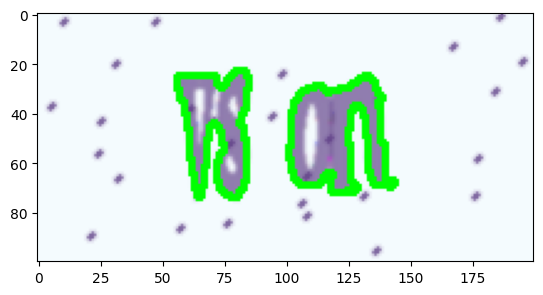

In [14]:
train_data_folder = "CAPTCHA_dataset/soft/train"

# for img in os.listdir(train_data_folder):

image_path = os.path.join(train_data_folder, "vs0n.png")
image = cv.imread(image_path)

gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# adaptive thresholding
_, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# to get rid of very small contours
threshold = 100
contours = [contour for contour in contours if cv.contourArea(contour) > threshold]

# draw contours
image2 = image.copy()

# draw contours
cv.drawContours(image2, contours, -1, (0, 255, 0), 2)

# draw bounding boxes
# for contour in contours:
#     x, y, w, h = cv.boundingRect(contour)
#     cv.rectangle(image2, (x, y), (x + w, y + h), (0, 255, 0), 1)

# # create individual images based on bounding boxes
# individual_images = []
# x_values = []
# for contour in contours:
#     x, y, w, h = cv.boundingRect(contour)
#     x_values.append(x)
#     individual_image = image[y:y+h, x:x+w]
#     individual_images.append(individual_image)

# get the sorted idx of x_values -> this is to order the images from left to right, otherwise the contours are ordered in some other way
# sorted_idx = np.argsort(x_values) 
# # sort individual_images based on sorted_idx
# individual_images = [individual_images[i] for i in sorted_idx]


# for i in range(len(individual_images)):
#     cv.imwrite(f"individual_images/image_{i}.png", individual_images[i])

# plt.figure(figsize=(4,6), dpi=100)
# plt.subplot(2,2,1)
# plt.imshow(individual_images[0])
# plt.axis('off')
# plt.subplot(2,2,2)
# plt.imshow(individual_images[1])
# plt.axis('off')
# plt.subplot(2,2,3)
# plt.imshow(individual_images[2])
# plt.axis('off')
# plt.subplot(2,2,4)
# plt.imshow(individual_images[3])
# plt.axis('off')
# plt.show()

plt.imshow(image2)

# x, y, w, h = cv.boundingRect(all_contours)
# cv.rectangle(image2, (x, y), (x + w, y + h), (0, 255, 0), 2)

## Data

In [12]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform):

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # getting all image paths and labels
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)

            self.image_paths.append(img_path)

            label = img_name.split('.')[0][0] # removing the .png from the name and choosing the first character
            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths) # to get the len(dataset)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # labels should be a list of characters
        label = list(label)
        return image, label

In [13]:
char_map = {ch: idx for idx, ch in enumerate("0123456789abcdefghijklmnopqrstuvwxyz")}
idx_to_char = {idx: ch for ch, idx in char_map.items()}  # Reverse mapping

char_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [14]:
def collate_fn(batch):

    images = []
    labels = []

    for image, label in batch:
        images.append(image)
        # label to indices
        label_indices = torch.tensor([char_map[ch] for ch in label], dtype=torch.long)
        labels.append(label_indices)

    # tensor (batch_size, 3, H, W)
    images = torch.stack(images)

    return images, torch.tensor(labels)

In [15]:
transform = transforms.Compose([
    transforms.Resize((32, 16)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [25]:
train_dir = 'CAPTCHA_dataset/soft/train_ind'
test_dir = 'CAPTCHA_dataset/soft/test_ind'

train_dataset = CaptchaDataset(root_dir=train_dir, transform=transform)
test_dataset = CaptchaDataset(root_dir=test_dir, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [26]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22129
5533
6245


Image Batch Shape: torch.Size([32, 3, 32, 16])


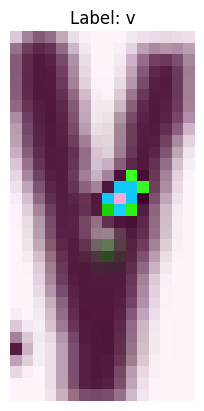

In [27]:
for images, labels in train_loader:
    print("Image Batch Shape:", images.shape)

    # first image in the batch
    first_image = images[0]
    label = labels[0]

    #converting label indices back to characters
    decoded_label = idx_to_char[label.item()]

    # this is for matplotlib to display
    first_image = func.to_pil_image(first_image)

    plt.imshow(first_image)
    plt.title(f"Label: {decoded_label}")
    plt.axis('off')
    plt.show()

    break

## Model

In [29]:
# Model Architecture

class CAPTCHA_CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CAPTCHA_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 8, 256) # 32x16 after two MaxPooling layers => 8x4
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
num_classes = 36
learning_rate = 0.001
epochs = 10

model = CAPTCHA_CNN(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(train_loader, val_loader):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")

def eval(test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [31]:
train(train_loader, val_loader)

Epoch [1/10], Train Loss: 0.8992, Validation Loss: 0.6335
Epoch [2/10], Train Loss: 0.4937, Validation Loss: 0.5679
Epoch [3/10], Train Loss: 0.4047, Validation Loss: 0.5726
Epoch [4/10], Train Loss: 0.3415, Validation Loss: 0.5583
Epoch [5/10], Train Loss: 0.2827, Validation Loss: 0.5977
Epoch [6/10], Train Loss: 0.2265, Validation Loss: 0.6355
Epoch [7/10], Train Loss: 0.1780, Validation Loss: 0.6972
Epoch [8/10], Train Loss: 0.1356, Validation Loss: 0.8364
Epoch [9/10], Train Loss: 0.1093, Validation Loss: 0.8710
Epoch [10/10], Train Loss: 0.0874, Validation Loss: 0.9395


In [34]:
eval(train_loader)

Test Accuracy: 98.26%
